In [1]:
from path import Path 
from scipy.stats import pearsonr, spearmanr, wilcoxon

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import os, warnings
warnings.filterwarnings('ignore')
import stan

figsize = stan.figsize
fontsize = stan.fontsize
dpi = stan.dpi

path = Path('df2plot_inR')
if not os.path.exists(path):
    os.makedirs(path)

## Loading ST dataset

In [2]:
id_list = {'CID4290': 'ER_1', 'CID4535': 'ER_2', 'CID44971': 'TNBC_4',
           'CID4465': 'TNBC_3', '1142243F': 'TNBC_1', '1160920F': 'TNBC_2'}
sample_list = id_list.keys()

adatas = dict() # input of STAN
adatas_stan = dict() # output of STAN
for sample_id in sample_list:
    adatas[sample_id] = sc.read_h5ad("data/Breast_Wu/{}.h5ad".format(sample_id))
    
    adata = sc.read_h5ad('outputs_stan/adata_Breast_Wu_{}.h5ad'.format(sample_id))
    # ridge new
    adata.obsm['tfa_ridge'] = pd.read_csv(f'outputs_stan/adata_Breast_Wu_{sample_id}_tfa_ridge.csv', index_col=0)
    adata.obs['pred_cor_ridge'] = pd.read_csv(f'outputs_stan/adata_Breast_Wu_{sample_id}_pred_cor_ridge.csv', index_col=0)
    # decoupler
    adata.obsm['ulm_estimate'] = pd.read_csv(f'benchmark_decoupler/ulm_Breast_Wu_{sample_id}.csv', index_col=0).loc[adata.obs.index,:]
    adatas_stan[sample_id] = adata

Extract the inferred TF activity matrix.

In [3]:
adatas_tfa = dict()
adatas_tfa_ridge = dict()
adatas_tfa_dec = dict()

for sample_id in sample_list:
    adata = adatas_stan[sample_id]
    adatas_tfa[sample_id] = stan.get_activity(adata, key='tfa_stan') 
    adatas_tfa_ridge[sample_id] = stan.get_activity(adata, key='tfa_ridge')
    adatas_tfa_dec[sample_id] = stan.get_activity(adata, key='ulm_estimate')

For mRNA expression, normalize each spot by total counts over all genes.

In [4]:
for sample_id in sample_list:
    sc.pp.normalize_total(adatas[sample_id])
    adatas[sample_id].layers['scaled'] = np.sqrt(adatas[sample_id].to_df())
    
    sc.pp.normalize_total(adatas_stan[sample_id])
    adatas_stan[sample_id].layers['scaled'] = np.sqrt(adatas_stan[sample_id].to_df())

## Visualizing the cross validation performance

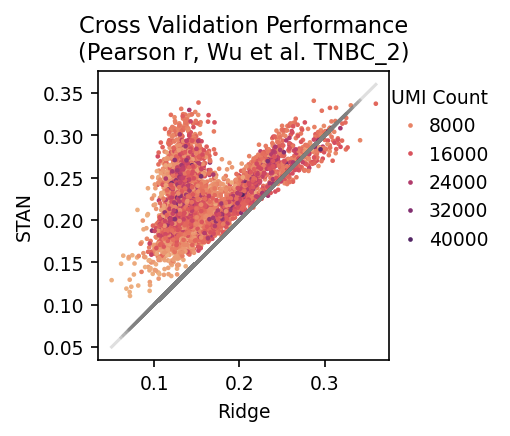

In [14]:
sample_id = 'CID4290'
sample_id = 'CID4535'
sample_id = 'CID44971'
sample_id = 'CID4465'
sample_id = '1142243F'
sample_id = '1160920F'
stan.plot_validation(adatas_stan[sample_id], xstring="pred_cor_ridge", 
                     title=f'Cross Validation Performance\n(Pearson r, Wu et al. {id_list[sample_id]})')

In [15]:
for sample_id in sample_list:
    print(id_list[sample_id])
    print(adatas_stan[sample_id].obs["pred_cor_stan"].mean())
    print(adatas_stan[sample_id].obs["pred_cor_stan"].std())
    print(adatas_stan[sample_id].obs["pred_cor_ridge"].mean())
    print(adatas_stan[sample_id].obs["pred_cor_ridge"].std())

ER_1
0.2549085820080196
0.03706745576709854
0.24078913880989378
0.04572010930652881
ER_2
0.29591756329185637
0.04912588601536363
0.28606042598066034
0.05586448619907836
TNBC_4
0.2869308552870781
0.04878851178236737
0.2452278350033944
0.07659095816517007
TNBC_3
0.24319994619222735
0.03564971893349697
0.21987059032300776
0.05228845107441493
TNBC_1
0.2149746845930054
0.02924966186410663
0.19653274992933262
0.036174100475381374
TNBC_2
0.2268365752370902
0.03630872276482159
0.16252317970391003
0.04423941001995269


In [20]:
for sample_id in sample_list:
    print(id_list[sample_id])
    print(wilcoxon(adatas_stan[sample_id].obs["pred_cor_stan"], adatas_stan[sample_id].obs["pred_cor_ridge"],
          zero_method='wilcox', correction=False, alternative='greater'))

ER_1
WilcoxonResult(statistic=2879389.0, pvalue=0.0)
ER_2
WilcoxonResult(statistic=504406.0, pvalue=1.7968981357196218e-137)
TNBC_4
WilcoxonResult(statistic=662499.0, pvalue=1.780071965324961e-178)
TNBC_3
WilcoxonResult(statistic=688137.0, pvalue=1.465243778855798e-157)
TNBC_1
WilcoxonResult(statistic=10729902.0, pvalue=0.0)
TNBC_2
WilcoxonResult(statistic=11677422.0, pvalue=0.0)


## Embedding and Clustering

In [21]:
def tune_resolution(adata, k=7):
    res_a = 0.1
    res_b = 1.5
    sc.tl.leiden(adata, resolution=res_a)
    na = len(adata.obs["leiden"].cat.categories)
    while na > k and res_a > 0:
        res_a -= 0.01
        sc.tl.leiden(adata, resolution=res_a)
        na = len(adata.obs["leiden"].cat.categories)
        if na==k:
            print(f'Resolution: {res_a}, {adata.obs["leiden"].cat.categories}')
            return adata
        
    sc.tl.leiden(adata, resolution=res_b)
    nb = len(adata.obs["leiden"].cat.categories)
    while nb < k:
        res_b += 0.1
        sc.tl.leiden(adata, resolution=res_b)
        nb = len(adata.obs["leiden"].cat.categories)
        if nb==k:
            print(f'Resolution: {res_b}, {adata.obs["leiden"].cat.categories}')
            return adata
    
    res_p = (res_a + res_b)/2
    sc.tl.leiden(adata, resolution=res_p)
    np = len(adata.obs["leiden"].cat.categories)
    while np!=k:
        if np>k:
            res_b = res_p
            sc.tl.leiden(adata, resolution=res_b)
            nb = len(adata.obs["leiden"].cat.categories)
        if np<k:
            res_a = res_p
            sc.tl.leiden(adata, resolution=res_a)
            na = len(adata.obs["leiden"].cat.categories)
        res_p = (res_a + res_b)/2
        sc.tl.leiden(adata, resolution=res_p)
        np = len(adata.obs["leiden"].cat.categories)
    print(f'Resolution: {res_p}, {adata.obs["leiden"].cat.categories}')
    return adata

In [22]:
adatas_tfa_scaled = dict()
adatas_tfa_ridge_scaled = dict()
adatas_tfa_dec_scaled = dict()
adatas_mrna = dict()

In [23]:
for sample_id in sample_list:
    print(f'---- {sample_id} ----')
    k = len(adatas_stan[sample_id].obs['pathology'].cat.categories)
    
    # TF (STAN)
    if sample_id not in adatas_tfa_scaled.keys():
        adata_tfa_scaled = adatas_tfa[sample_id].copy()[:, adatas_tfa[sample_id].to_df().dropna(axis=1).columns]
        sc.pp.scale(adata_tfa_scaled)
        sc.pp.neighbors(adata_tfa_scaled, n_neighbors=100)
        sc.tl.umap(adata_tfa_scaled, min_dist=0.01)
        adatas_tfa_scaled[sample_id] = tune_resolution(adata_tfa_scaled, k=k)
    
    # TF (Ridge)
    if sample_id not in adatas_tfa_ridge_scaled.keys():
        adata_tfa_ridge_scaled = adatas_tfa_ridge[sample_id].copy()[:, adatas_tfa_ridge[sample_id].to_df().dropna(axis=1).columns]
        sc.pp.scale(adata_tfa_ridge_scaled)
        sc.pp.neighbors(adata_tfa_ridge_scaled, n_neighbors=100)
        sc.tl.umap(adata_tfa_ridge_scaled, min_dist=0.01)
        adatas_tfa_ridge_scaled[sample_id] = tune_resolution(adata_tfa_ridge_scaled, k=k)
    
    # TF (decoupleR)
    if sample_id not in adatas_tfa_dec_scaled.keys():
        tfs = adatas_tfa_dec[sample_id].var_names.intersection(adatas_stan[sample_id].varm['gene_tf'].columns)
        adata_dec_scaled = adatas_tfa_dec[sample_id].copy()[:, tfs]
        sc.pp.scale(adata_dec_scaled)
        sc.pp.neighbors(adata_dec_scaled, n_neighbors=100)
        sc.tl.umap(adata_dec_scaled, min_dist=0.01)
        adatas_tfa_dec_scaled[sample_id] = tune_resolution(adata_dec_scaled, k=k)
    
    # mRNA
    if sample_id not in adatas_mrna.keys():
        tfs = adatas[sample_id].var_names.intersection(adatas_stan[sample_id].varm['gene_tf'].columns)
        adata_scaled = adatas[sample_id].copy()
        sc.pp.log1p(adata_scaled)
        sc.pp.scale(adata_scaled)
        adata_scaled_subset = adata_scaled[:, tfs].copy()
        sc.pp.neighbors(adata_scaled_subset, n_neighbors=100)
        sc.tl.umap(adata_scaled_subset, min_dist=0.01)
        adatas_mrna[sample_id] = tune_resolution(adata_scaled_subset, k=k)  

---- CID4290 ----
Resolution: 0.121875, Index(['0', '1', '2'], dtype='object')
Resolution: 0.45, Index(['0', '1', '2'], dtype='object')
Resolution: 0.275, Index(['0', '1', '2'], dtype='object')
Resolution: 0.5375, Index(['0', '1', '2'], dtype='object')
---- CID4535 ----
Resolution: 0.58125, Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Resolution: 1.325, Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Resolution: 0.8, Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Resolution: 0.9421875, Index(['0', '1', '2', '3', '4', '5'], dtype='object')
---- CID44971 ----
Resolution: 0.625, Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Resolution: 1.15, Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Resolution: 0.7125, Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Resolution: 0.975, Index(['0', '1', '2', '3', '4', '5'], dtype='object')
---- CID4465 ----
Resolution: 0.14375, Index(['0', '1', '2'], dtype='object')
Resolution: 0.45, Index(['0', '1', '2'], dty

### ARI

In [24]:
import sklearn
from sklearn.preprocessing import OrdinalEncoder
def compute_ari(adata, cluster_1, cluster_2):
    # Extract labels and drop rows with NaN values
    label_1 = adata.obs[cluster_1].dropna()
    label_2 = adata.obs[cluster_2].dropna()

    # Ensure the indices match after dropping NaN values
    common_index = label_1.index.intersection(label_2.index)
    label_1 = label_1[common_index]
    label_2 = label_2[common_index]

    # Reshape and encode labels
    sklearn_encoder = OrdinalEncoder()
    encoder_1 = sklearn_encoder.fit_transform(label_1.values.reshape(-1, 1))
    encoder_2 = sklearn_encoder.fit_transform(label_2.values.reshape(-1, 1))

    # Compute Adjusted Rand Index
    ari = sklearn.metrics.adjusted_rand_score(encoder_1.flatten(), encoder_2.flatten())
    return ari

In [25]:
df_ari = pd.DataFrame(index=sample_list)
cluster_1 = 'pathology'
cluster_2 = 'leiden'

for sample_id in sample_list:
    df_ari.loc[sample_id, 'STAN'] = compute_ari(adatas_tfa_scaled[sample_id], cluster_1, cluster_2)
    df_ari.loc[sample_id, 'Ridge'] = compute_ari(adatas_tfa_ridge_scaled[sample_id], cluster_1, cluster_2)
    df_ari.loc[sample_id, 'DecoupleR'] = compute_ari(adatas_tfa_dec_scaled[sample_id], cluster_1, cluster_2)
    df_ari.loc[sample_id, 'TF mRNA'] = compute_ari(adatas_mrna[sample_id], cluster_1, cluster_2)

# df_ari.index = id_list.values()
df_ari

STAN     Ridge  DecoupleR   TF mRNA
CID4290   0.195347  0.085585   0.006900  0.000288
CID4535   0.327820  0.089089   0.090654  0.048108
CID44971  0.691448  0.364482   0.322495  0.418636
CID4465  -0.033926  0.011983  -0.013903 -0.007754
1142243F  0.021983  0.008688  -0.003674 -0.009276
1160920F  0.189217  0.071614   0.082120  0.168677

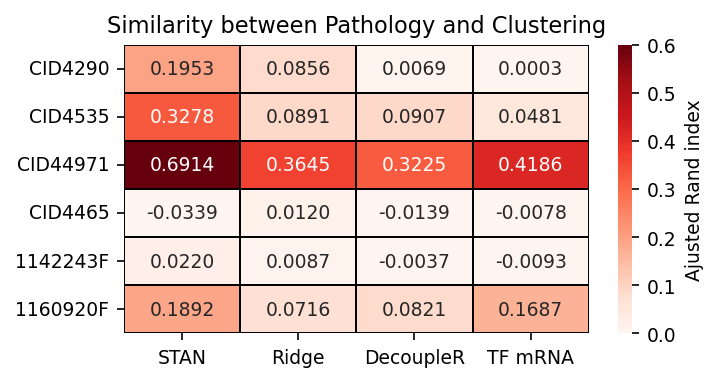

In [26]:
plt.figure(figsize=(figsize*2, figsize), dpi=dpi)
plt.rc('font', size=fontsize)
ax = sns.heatmap(df_ari.loc[:, ['STAN', 'Ridge', 'DecoupleR', 'TF mRNA']].astype(float), 
                 annot=True, cmap="Reds", vmax=0.6, vmin=0, fmt='.4f',
                 linewidths=0.8, linecolor='black')
ax.set_xlabel("")
ax.set_ylabel("")
# plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.title('Similarity between Pathology and Clustering')
colorbar = ax.collections[0].colorbar
colorbar.set_label('Ajusted Rand index', fontsize=fontsize)

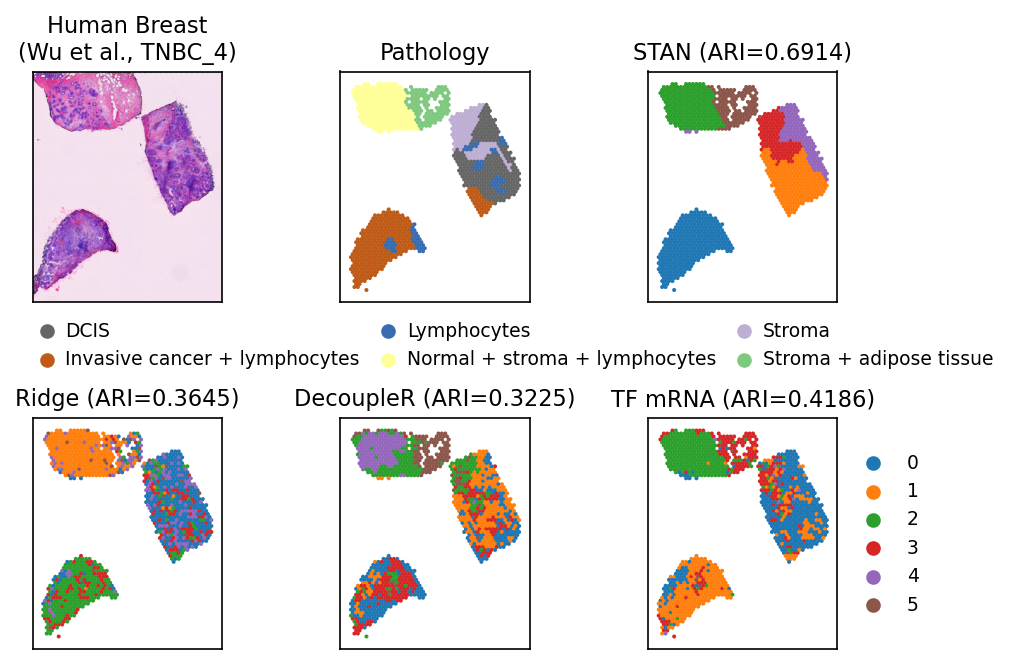

In [51]:
sample_id = 'CID44971'
# Create figure with constrained layout and extra vertical space
fig = plt.figure(figsize=(3*figsize, 2*figsize), dpi=dpi, constrained_layout=True)
plt.rc('font', size=fontsize)

# Create 6 subplots with adjusted vertical spacing
gs = fig.add_gridspec(2, 3, hspace=0.5)  # hspace controls vertical gap
axes = [fig.add_subplot(gs[i]) for i in range(6)]

# Your original plotting code (unchanged)
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[0], show=False, 
              title=f'Human Breast\n(Wu et al., {id_list[sample_id]})')
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[1], color='pathology', palette='Accent_r', alpha_img=0, size=1.8, 
              show=False, title="Pathology", legend_fontsize=fontsize, na_in_legend=False)
sc.pl.spatial(adatas_tfa_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[2], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_ridge_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[3], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_dec_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[4], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_mrna[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[5], 
              show=False, frameon=True, legend_fontsize=fontsize)

# Axis cleanup (unchanged)
for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for i in [2,3,4]:
    axes[i].legend().remove()

# Custom legend positioning (centered vertically)
axes[1].legend(title='', loc='lower center', bbox_to_anchor=(0.9, -0.36), columnspacing=0.5, ncol=3, handletextpad=0, frameon=False)

# Add ARI scores
axes[2].set_title(f"STAN (ARI={df_ari.loc[sample_id, 'STAN']:.4f})")
axes[3].set_title(f"Ridge (ARI={df_ari.loc[sample_id, 'Ridge']:.4f})") 
axes[4].set_title(f"DecoupleR (ARI={df_ari.loc[sample_id, 'DecoupleR']:.4f})")
axes[5].set_title(f"TF mRNA (ARI={df_ari.loc[sample_id, 'TF mRNA']:.4f})")

plt.tight_layout(pad=0.01)
plt.show()

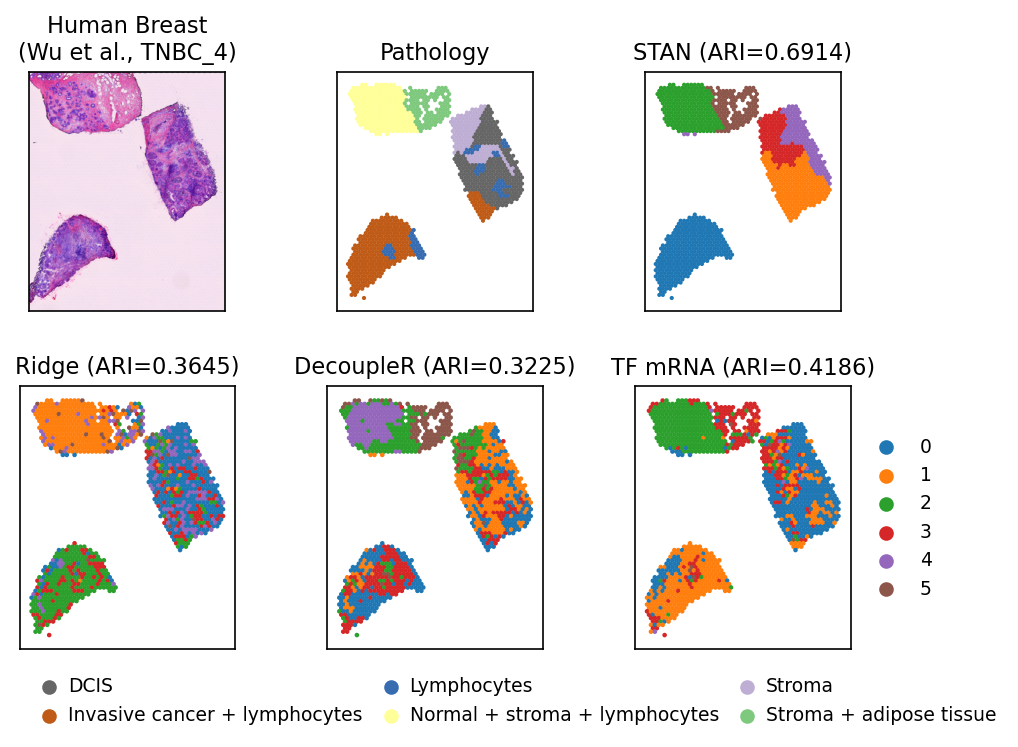

In [88]:
sample_id = 'CID44971'
# Create figure with constrained layout and extra vertical space
fig = plt.figure(figsize=(3*figsize, 2*figsize), dpi=dpi)
plt.rc('font', size=fontsize)

# Create 6 subplots with adjusted vertical spacing
gs = fig.add_gridspec(2, 3, hspace=0.3, height_ratios=[1, 1.1])  
axes = [fig.add_subplot(gs[i]) for i in range(6)]

# Your original plotting code (unchanged)
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[0], show=False, 
              title=f'Human Breast\n(Wu et al., {id_list[sample_id]})')
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[1], color='pathology', palette='Accent_r', alpha_img=0, size=1.8, 
              show=False, title="Pathology", legend_fontsize=fontsize, na_in_legend=False)
sc.pl.spatial(adatas_tfa_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[2], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_ridge_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[3], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_dec_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[4], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_mrna[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[5], 
              show=False, frameon=True, legend_fontsize=fontsize)

# Axis cleanup (unchanged)
for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for i in [2,3,4]:
    axes[i].legend().remove()

# Custom legend positioning (centered vertically)
axes[1].legend(title='', loc='lower center', bbox_to_anchor=(0.9, -1.8), columnspacing=0.5, ncol=3, handletextpad=0, frameon=False)

# Add ARI scores
axes[2].set_title(f"STAN (ARI={df_ari.loc[sample_id, 'STAN']:.4f})")
axes[3].set_title(f"Ridge (ARI={df_ari.loc[sample_id, 'Ridge']:.4f})") 
axes[4].set_title(f"DecoupleR (ARI={df_ari.loc[sample_id, 'DecoupleR']:.4f})")
axes[5].set_title(f"TF mRNA (ARI={df_ari.loc[sample_id, 'TF mRNA']:.4f})")

plt.tight_layout(pad=0.5)
plt.show()

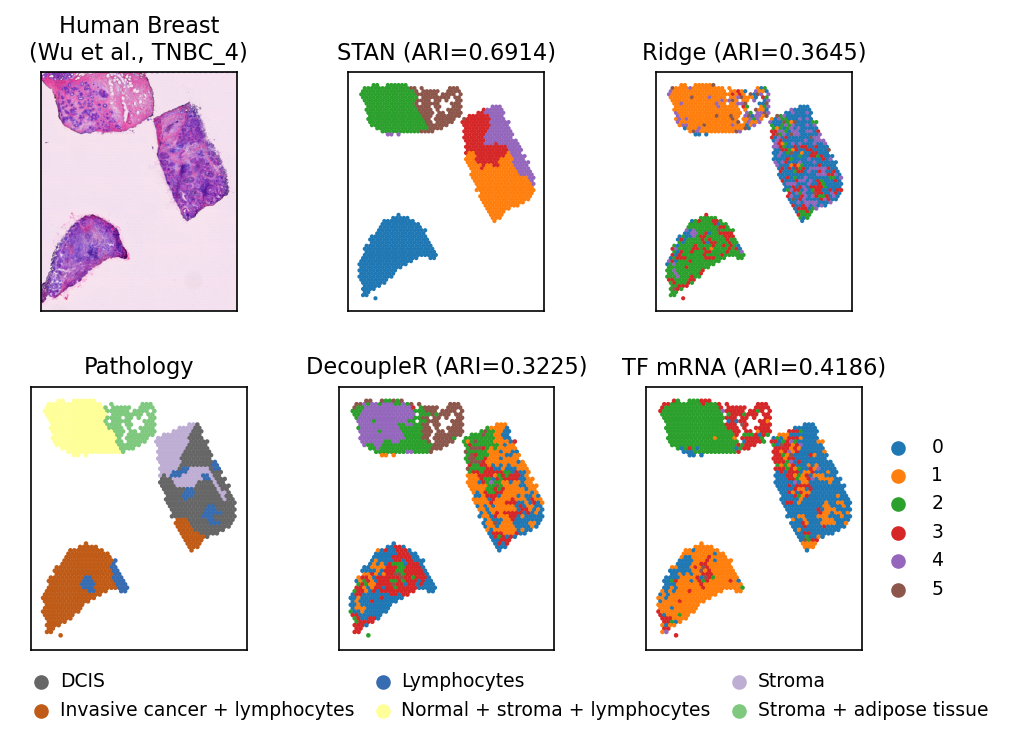

In [96]:
sample_id = 'CID44971'
# Create figure with constrained layout and extra vertical space
fig = plt.figure(figsize=(3*figsize, 2*figsize), dpi=dpi)
plt.rc('font', size=fontsize)

# Create 6 subplots with adjusted vertical spacing
gs = fig.add_gridspec(2, 3, hspace=0.3, height_ratios=[1, 1.1])  
axes = [fig.add_subplot(gs[i]) for i in range(6)]

# Your original plotting code (unchanged)
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[0], show=False, 
              title=f'Human Breast\n(Wu et al., {id_list[sample_id]})')
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[3], color='pathology', palette='Accent_r', alpha_img=0, size=1.8, 
              show=False, title="Pathology", legend_fontsize=fontsize, na_in_legend=False)
sc.pl.spatial(adatas_tfa_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[1], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_ridge_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[2], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_dec_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[4], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_mrna[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[5], 
              show=False, frameon=True, legend_fontsize=fontsize)

# Axis cleanup (unchanged)
for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for i in [1,2,4]:
    axes[i].legend().remove()

# Custom legend positioning (centered vertically)
axes[3].legend(title='', loc='lower center', bbox_to_anchor=(2.2, -0.33), columnspacing=0.5, ncol=3, handletextpad=0, frameon=False)

# Add ARI scores
axes[1].set_title(f"STAN (ARI={df_ari.loc[sample_id, 'STAN']:.4f})")
axes[2].set_title(f"Ridge (ARI={df_ari.loc[sample_id, 'Ridge']:.4f})") 
axes[4].set_title(f"DecoupleR (ARI={df_ari.loc[sample_id, 'DecoupleR']:.4f})")
axes[5].set_title(f"TF mRNA (ARI={df_ari.loc[sample_id, 'TF mRNA']:.4f})")

plt.tight_layout(pad=0.5)
plt.show()

Text(0.5, 1.0, 'TF mRNA (ARI=0.1687)')

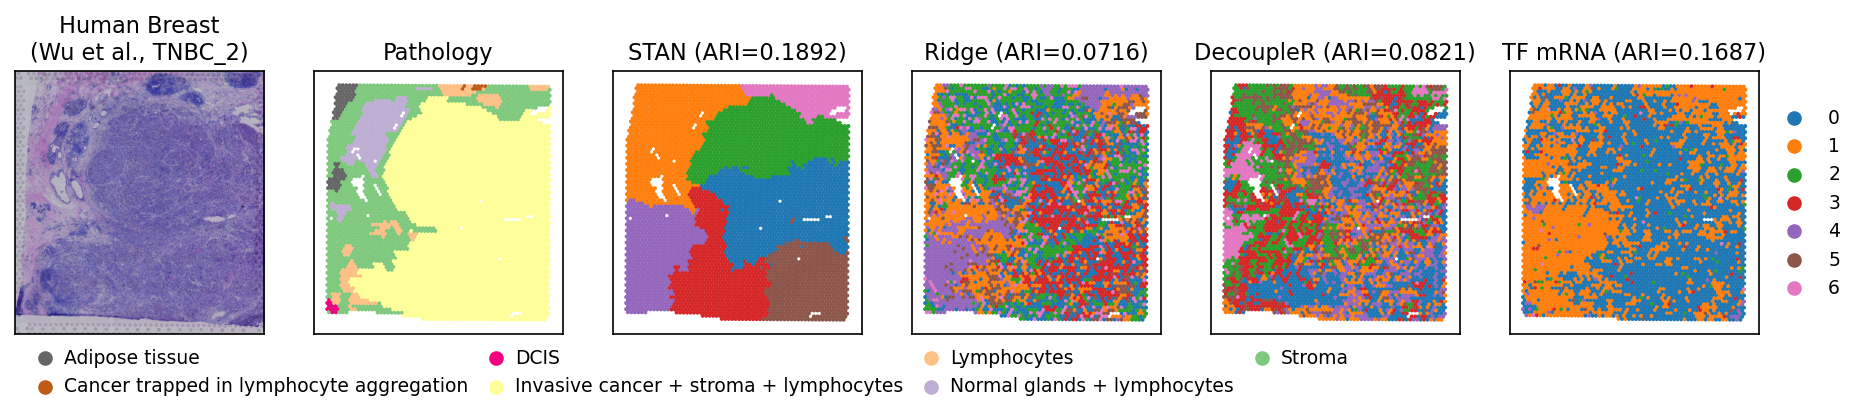

In [50]:
sample_id = '1160920F'
fig, axes = plt.subplots(1,6, figsize=(6*figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[0], show=False, 
              title=f'Human Breast\n(Wu et al., {id_list[sample_id]})')
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[1], color='pathology', palette='Accent_r', alpha_img=0, size=1.8, 
              show=False, title="Pathology", legend_fontsize=fontsize, na_in_legend=False)
sc.pl.spatial(adatas_tfa_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[2], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_ridge_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[3], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_dec_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[4], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_mrna[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[5], 
              show=False, frameon=True, legend_fontsize=fontsize)

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for i in [2,3,4]:
    axes[i].legend().remove()
    
axes[1].legend(title='', loc='lower center', bbox_to_anchor=(1.5, -0.3), columnspacing=0.5, ncol=4, handletextpad=0, frameon=False)
axes[2].set_title(f"STAN (ARI={df_ari.loc[sample_id, 'STAN']:.4f})")
axes[3].set_title(f"Ridge (ARI={df_ari.loc[sample_id, 'Ridge']:.4f})")
axes[4].set_title(f"DecoupleR (ARI={df_ari.loc[sample_id, 'DecoupleR']:.4f})")
axes[5].set_title(f"TF mRNA (ARI={df_ari.loc[sample_id, 'TF mRNA']:.4f})")

Text(0.5, 1.0, 'TF mRNA (ARI=-0.0078)')

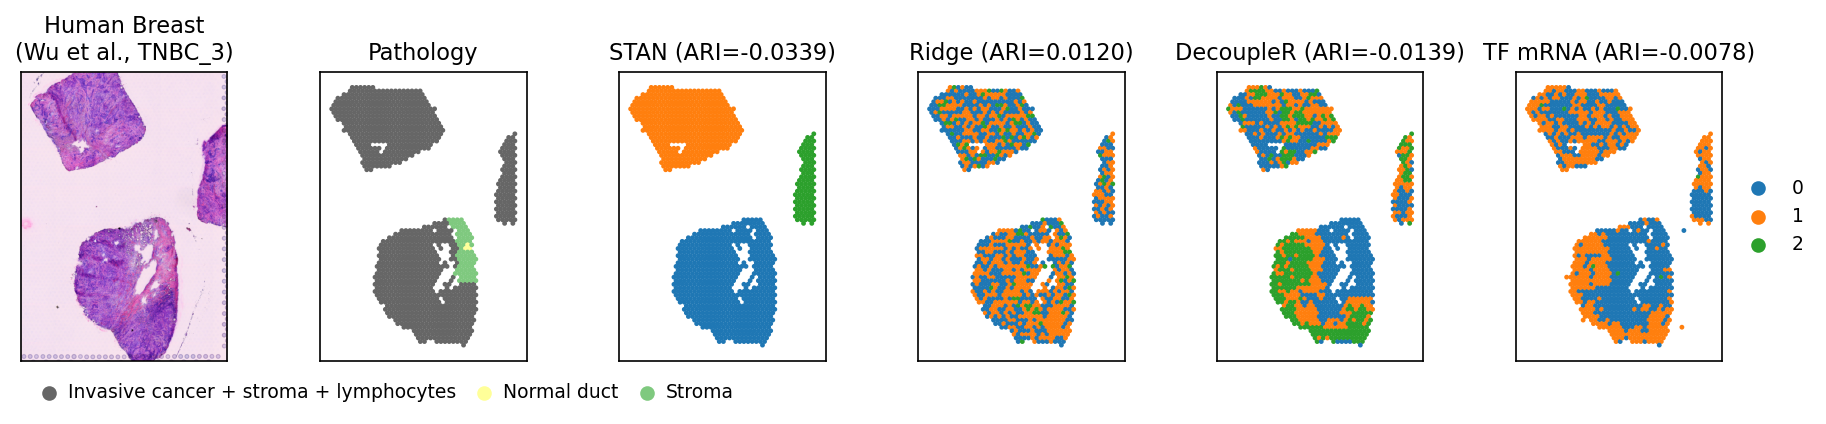

In [52]:
sample_id = 'CID4465'
fig, axes = plt.subplots(1,6, figsize=(6*figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[0], show=False, 
              title=f'Human Breast\n(Wu et al., {id_list[sample_id]})')
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[1], color='pathology', palette='Accent_r', alpha_img=0, size=1.8, 
              show=False, title="Pathology", legend_fontsize=fontsize, na_in_legend=False)
sc.pl.spatial(adatas_tfa_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[2], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_ridge_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[3], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_dec_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[4], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_mrna[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[5], 
              show=False, frameon=True, legend_fontsize=fontsize)

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for i in [2,3,4]:
    axes[i].legend().remove()
    
axes[1].legend(title='', loc='lower center', bbox_to_anchor=(0.3, -0.2), columnspacing=0.5, ncol=3, handletextpad=0, frameon=False)
axes[2].set_title(f"STAN (ARI={df_ari.loc[sample_id, 'STAN']:.4f})")
axes[3].set_title(f"Ridge (ARI={df_ari.loc[sample_id, 'Ridge']:.4f})")
axes[4].set_title(f"DecoupleR (ARI={df_ari.loc[sample_id, 'DecoupleR']:.4f})")
axes[5].set_title(f"TF mRNA (ARI={df_ari.loc[sample_id, 'TF mRNA']:.4f})")

Text(0.5, 1.0, 'TF mRNA (ARI=0.0003)')

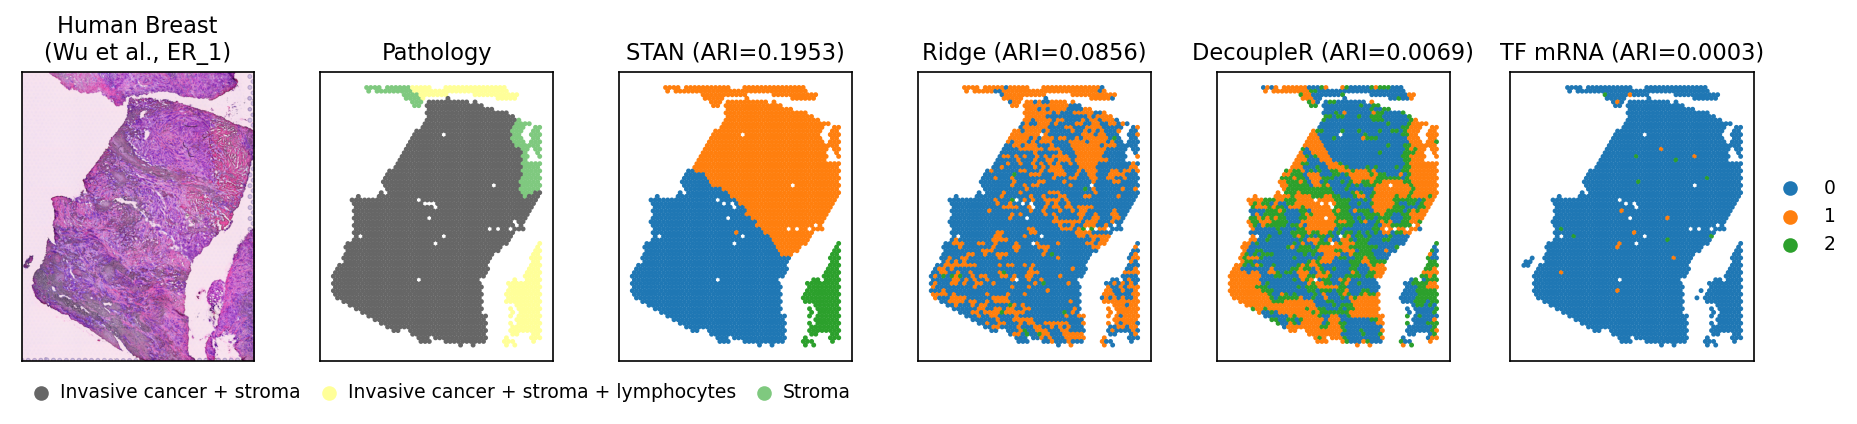

In [53]:
sample_id = 'CID4290'
fig, axes = plt.subplots(1,6, figsize=(6*figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[0], show=False, 
              title=f'Human Breast\n(Wu et al., {id_list[sample_id]})')
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[1], color='pathology', palette='Accent_r', alpha_img=0, size=1.8, 
              show=False, title="Pathology", legend_fontsize=fontsize, na_in_legend=False)
sc.pl.spatial(adatas_tfa_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[2], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_ridge_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[3], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_dec_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[4], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_mrna[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[5], 
              show=False, frameon=True, legend_fontsize=fontsize)

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for i in [2,3,4]:
    axes[i].legend().remove()
    
axes[1].legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.2), columnspacing=0.5, ncol=3, handletextpad=0, frameon=False)
axes[2].set_title(f"STAN (ARI={df_ari.loc[sample_id, 'STAN']:.4f})")
axes[3].set_title(f"Ridge (ARI={df_ari.loc[sample_id, 'Ridge']:.4f})")
axes[4].set_title(f"DecoupleR (ARI={df_ari.loc[sample_id, 'DecoupleR']:.4f})")
axes[5].set_title(f"TF mRNA (ARI={df_ari.loc[sample_id, 'TF mRNA']:.4f})")

Text(0.5, 1.0, 'TF mRNA (ARI=0.0481)')

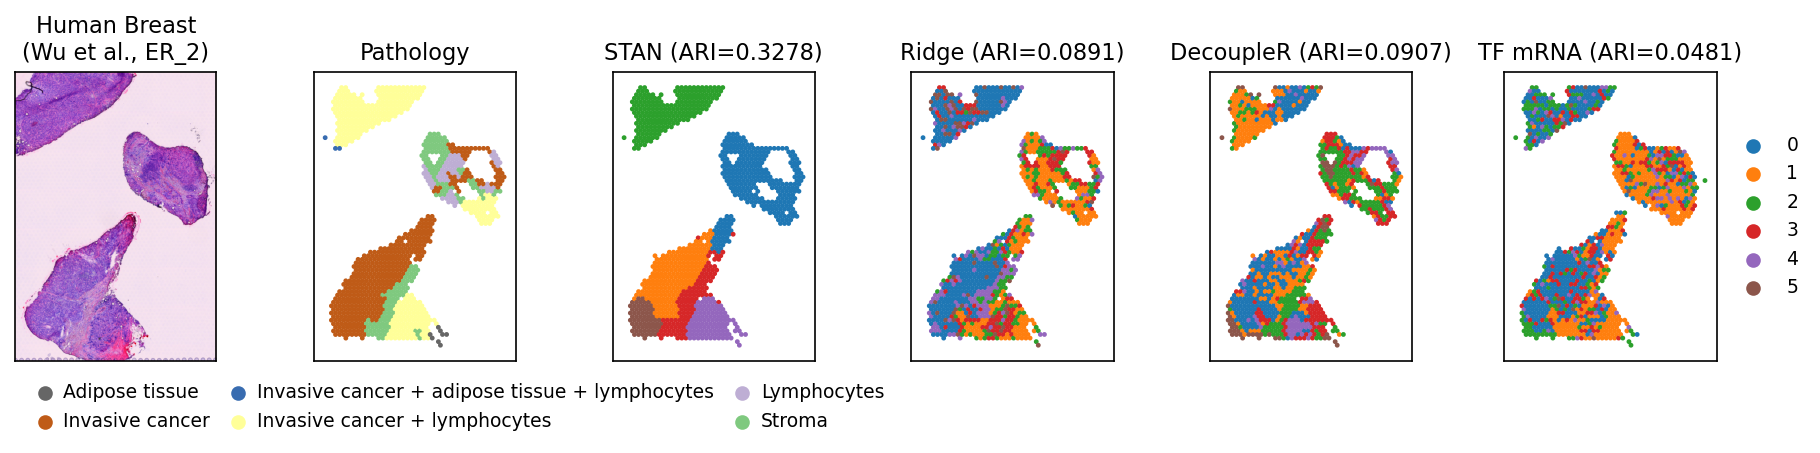

In [54]:
sample_id = 'CID4535'
fig, axes = plt.subplots(1,6, figsize=(6*figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[0], show=False, 
              title=f'Human Breast\n(Wu et al., {id_list[sample_id]})')
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[1], color='pathology', palette='Accent_r', alpha_img=0, size=1.8, 
              show=False, title="Pathology", legend_fontsize=fontsize, na_in_legend=False)
sc.pl.spatial(adatas_tfa_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[2], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_ridge_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[3], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_dec_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[4], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_mrna[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[5], 
              show=False, frameon=True, legend_fontsize=fontsize)

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for i in [2,3,4]:
    axes[i].legend().remove()
    
axes[1].legend(title='', loc='lower center', bbox_to_anchor=(0.7, -0.3), columnspacing=0.5, ncol=3, handletextpad=0, frameon=False)
axes[2].set_title(f"STAN (ARI={df_ari.loc[sample_id, 'STAN']:.4f})")
axes[3].set_title(f"Ridge (ARI={df_ari.loc[sample_id, 'Ridge']:.4f})")
axes[4].set_title(f"DecoupleR (ARI={df_ari.loc[sample_id, 'DecoupleR']:.4f})")
axes[5].set_title(f"TF mRNA (ARI={df_ari.loc[sample_id, 'TF mRNA']:.4f})")

Text(0.5, 1.0, 'TF mRNA (ARI=-0.0093)')

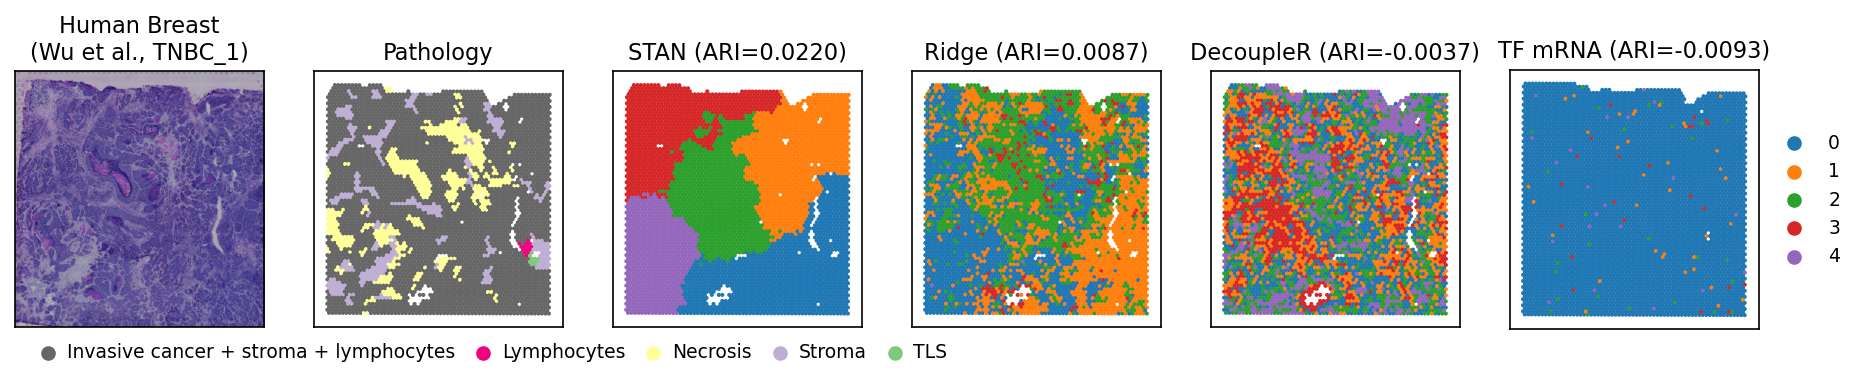

In [56]:
sample_id = '1142243F'
fig, axes = plt.subplots(1,6, figsize=(6*figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[0], show=False, 
              title=f'Human Breast\n(Wu et al., {id_list[sample_id]})')
sc.pl.spatial(adatas_tfa_scaled[sample_id], ax=axes[1], color='pathology', palette='Accent_r', alpha_img=0, size=1.8, 
              show=False, title="Pathology", legend_fontsize=fontsize, na_in_legend=False)
sc.pl.spatial(adatas_tfa_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[2], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_ridge_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[3], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_tfa_dec_scaled[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[4], 
              show=False, frameon=True, legend_fontsize=fontsize)
sc.pl.spatial(adatas_mrna[sample_id], color="leiden", size=1.8, alpha_img=0, ax=axes[5], 
              show=False, frameon=True, legend_fontsize=fontsize)

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for i in [2,3,4]:
    axes[i].legend().remove()
    
axes[1].legend(title='', loc='lower center', bbox_to_anchor=(0.7, -0.2), columnspacing=0.5, ncol=5, handletextpad=0, frameon=False)
axes[2].set_title(f"STAN (ARI={df_ari.loc[sample_id, 'STAN']:.4f})")
axes[3].set_title(f"Ridge (ARI={df_ari.loc[sample_id, 'Ridge']:.4f})")
axes[4].set_title(f"DecoupleR (ARI={df_ari.loc[sample_id, 'DecoupleR']:.4f})")
axes[5].set_title(f"TF mRNA (ARI={df_ari.loc[sample_id, 'TF mRNA']:.4f})")

### Precision score

In [57]:
def compute_precision(adata):
    pathologies = adata.obs['pathology'].cat.categories
    clusters = adata.obs['leiden'].cat.categories
    
    df_score = pd.DataFrame(index=pathologies, columns=clusters)
    for pat in pathologies:
        for clu in clusters:
            label_true = np.array(adata.obs['pathology']==pat).reshape(-1)
            label_pred = np.array(adata.obs['leiden']==clu).reshape(-1)
            df_score.loc[pat, clu] = sklearn.metrics.precision_score(y_true=label_true, y_pred=label_pred)
    return df_score

Text(0.5, 1.0, 'Precision Score\nHuman Breast (Wu et al., TNBC_1)')

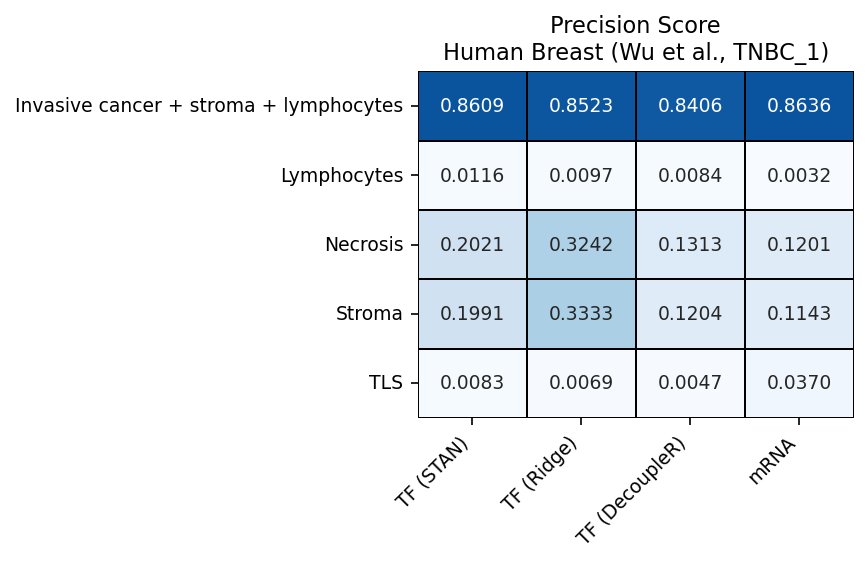

In [66]:
sample_id = '1142243F'
df_scores = dict()
df_scores['TF (STAN)'] = compute_precision(adatas_tfa_scaled[sample_id])
df_scores['TF (Ridge)'] = compute_precision(adatas_tfa_ridge_scaled[sample_id])
df_scores['TF (DecoupleR)'] = compute_precision(adatas_tfa_dec_scaled[sample_id])
df_scores['mRNA'] = compute_precision(adatas_mrna[sample_id])

df_precision = pd.DataFrame(index=None, columns=df_scores.keys())
for key in df_scores.keys():
    df_precision[key] = df_scores[key].max(axis=1)
    
plt.figure(figsize=(figsize*1.5, figsize*1.2), dpi=dpi)
plt.rc('font', size=fontsize)
ax = sns.heatmap(df_precision.astype(float), annot=True, cmap="Blues", vmax=1, vmin=0, fmt='.4f',
                 linewidths=0.8, linecolor='black', cbar=False)
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.title(f'Precision Score\nHuman Breast (Wu et al., {id_list[sample_id]})')
# colorbar = ax.collections[0].colorbar
# colorbar.set_label('Pearson r', fontsize=fontsize)

## Visualizing TFa in spatial coordinates by pathology

In [67]:
for sample_id in sample_list:
    sc.tl.rank_genes_groups(adatas_tfa[sample_id], groupby='pathology', method="wilcoxon")

In [68]:
pathlogy_list = {'Adipose tissue' : 'Adipose tissue',
    'Cancer trapped in lymphocyte aggregation' : 'Cancer trapped in\n lymphocyte aggregation',
    'DCIS': 'DCIS',
    'Invasive cancer' : 'Invasive cancer',
    'Invasive cancer + adipose tissue + lymphocytes' : 'Invasive cancer + adipose tissue\n+ lymphocytes',
    'Invasive cancer + lymphocytes' : 'Invasive cancer\n+ lymphocytes',
    'Invasive cancer + stroma' : 'Invasive cancer\n+ stroma',
    'Invasive cancer + stroma + lymphocytes' : 'Invasive cancer +\nstroma + lymphocytes',
    'Lymphocytes' : 'Lymphocytes',
    'Necrosis' : 'Necrosis',
    'Normal + stroma + lymphocytes' : 'Normal + stroma\n+ lymphocytes',
    'Normal duct' : 'Normal duct',
    'Normal glands + lymphocytes' : 'Normal glands\n+ lymphocytes',
    'Stroma' : 'Stroma',
    'Stroma + adipose tissue' : 'Stroma + adipose tissue',
    'TLS' : 'TLS'}

In [71]:
bpath = Path('results_breast')
os.makedirs(bpath, exist_ok=True)
bpath = bpath / 'pathology'
os.makedirs(bpath, exist_ok=True)

import auxiliary_breast as auxbr
for sample_id in sample_list:
    adata = adatas[sample_id].copy()
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    adata_tfa = adatas_tfa[sample_id]
    categories = adata_tfa.obs['pathology'].cat.categories

    ngenes = len(categories)
    points_list = dict()
    edge_list = dict()
    for i in range(len(categories)):
        points, edges = auxbr.find_edges(adata, sample_id, categories[i])
        points_list[categories[i]] = points
        edge_list[categories[i]] = edges
    
    fig, axs = plt.subplots(2, ngenes, figsize=(ngenes*figsize*0.8, figsize*1.6), dpi=dpi)
    for i in range(ngenes):
        sc.pl.spatial(adata_tfa, color=adata_tfa.uns['rank_genes_groups']['names'][0][i], 
            size=1.8, alpha_img=0, color_map="plasma", ax=axs[0,i], show=False, 
            legend_fontsize=fontsize*0.8, colorbar_loc='right')
        sc.pl.spatial(adata, color=adata_tfa.uns['rank_genes_groups']['names'][0][i], 
            size=1.8, alpha_img=0, color_map="viridis", ax=axs[1,i], show=False, 
            legend_fontsize=fontsize*0.8, colorbar_loc='right')
        axs[0,i].set_title(pathlogy_list[categories[i]] + '\n' + adata_tfa.uns['rank_genes_groups']['names'][0][i] + ' activity', fontsize=fontsize)
        axs[1,i].set_title(adata_tfa.uns['rank_genes_groups']['names'][0][i] + ' mRNA expr', fontsize=fontsize)
        for j in range(2):
            axs[j,i].set_xlabel("")
            axs[j,i].set_ylabel("")
            
        edges = edge_list[categories[i]]
        points = points_list[categories[i]]
        for ii, jj in edges:
            axs[0,i].plot(points[[ii, jj], 0], points[[ii, jj], 1], 'k', linewidth=0.8)
            axs[1,i].plot(points[[ii, jj], 0], points[[ii, jj], 1], 'w', linewidth=0.8)
    plt.tight_layout(pad=0.6)
    plt.savefig(bpath/'{}.png'.format(id_list[sample_id]))
    plt.close()

In [72]:
sample_id = 'CID44971'
adata = adatas[sample_id].copy()
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata_tfa = adatas_tfa[sample_id]
categories = ['Invasive cancer + lymphocytes', 'Lymphocytes', 'Normal + stroma + lymphocytes']

points_list = dict()
edge_list = dict()
for i in range(len(categories)):
    points, edges = auxbr.find_edges(adata, sample_id, categories[i])
    points_list[categories[i]] = points
    edge_list[categories[i]] = edges

tf_region = [
    ['FOXP3', 'Lymphocytes', 'Lymphocytes \n'],
    ['FOXA1', 'Normal + stroma + lymphocytes', 'Normal + stroma \n+ lymphocytes'],
    ['IRF2', 'Invasive cancer + lymphocytes', 'Invasive cancer \n + lymphocytes'],
    ['STAT2', 'Invasive cancer + lymphocytes', 'Invasive cancer \n + lymphocytes']
]
ngenes = len(tf_region)

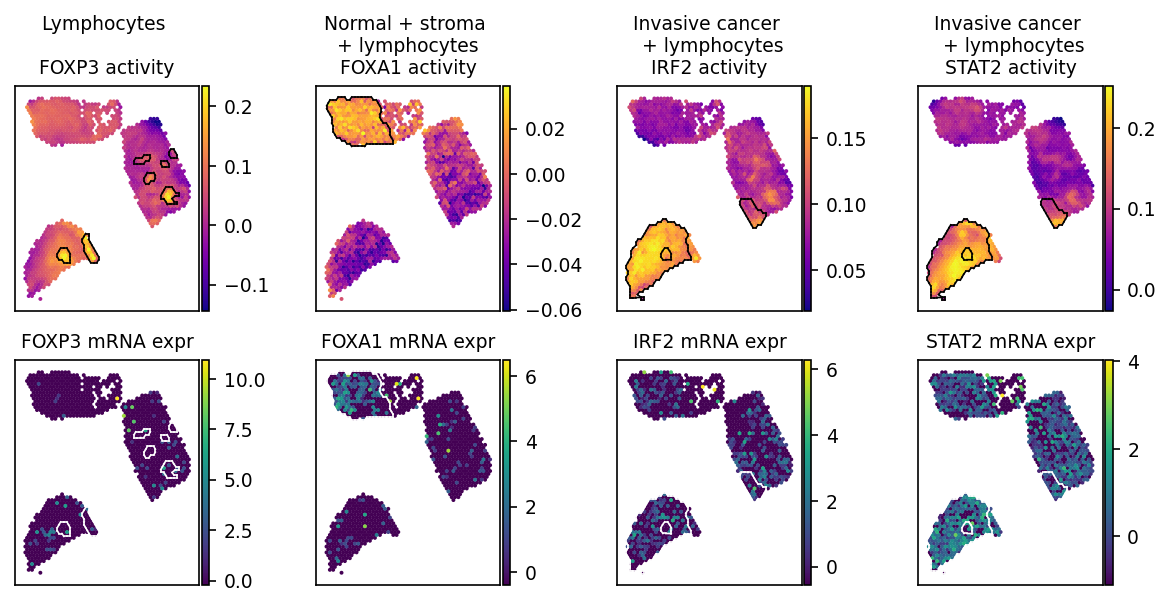

In [73]:
fig, axs = plt.subplots(2, ngenes, figsize=(ngenes*figsize*0.8, figsize*1.6), dpi=dpi)
for i in range(ngenes):
    sc.pl.spatial(adata_tfa, color=tf_region[i][0], 
        size=1.8, alpha_img=0, color_map="plasma", ax=axs[0,i], show=False, 
        legend_fontsize=fontsize*0.8, colorbar_loc='right')
    sc.pl.spatial(adata, color=tf_region[i][0], 
        size=1.8, alpha_img=0, color_map="viridis", ax=axs[1,i], show=False, 
        legend_fontsize=fontsize*0.8, colorbar_loc='right')
    axs[0,i].set_title(tf_region[i][2] + '\n' + tf_region[i][0] + ' activity', fontsize=fontsize)
    axs[1,i].set_title(tf_region[i][0] + ' mRNA expr', fontsize=fontsize)
    for j in range(2):
        axs[j,i].set_xlabel("")
        axs[j,i].set_ylabel("")

    edges = edge_list[tf_region[i][1]]
    points = points_list[tf_region[i][1]]
    for ii, jj in edges:
        axs[0,i].plot(points[[ii, jj], 0], points[[ii, jj], 1], 'k', linewidth=0.8)
        axs[1,i].plot(points[[ii, jj], 0], points[[ii, jj], 1], 'w', linewidth=0.8)
plt.tight_layout(pad=0.6)
# plt.savefig(bpath/'pathology/{}.png'.format(id_list[sample_id]))
# plt.close()

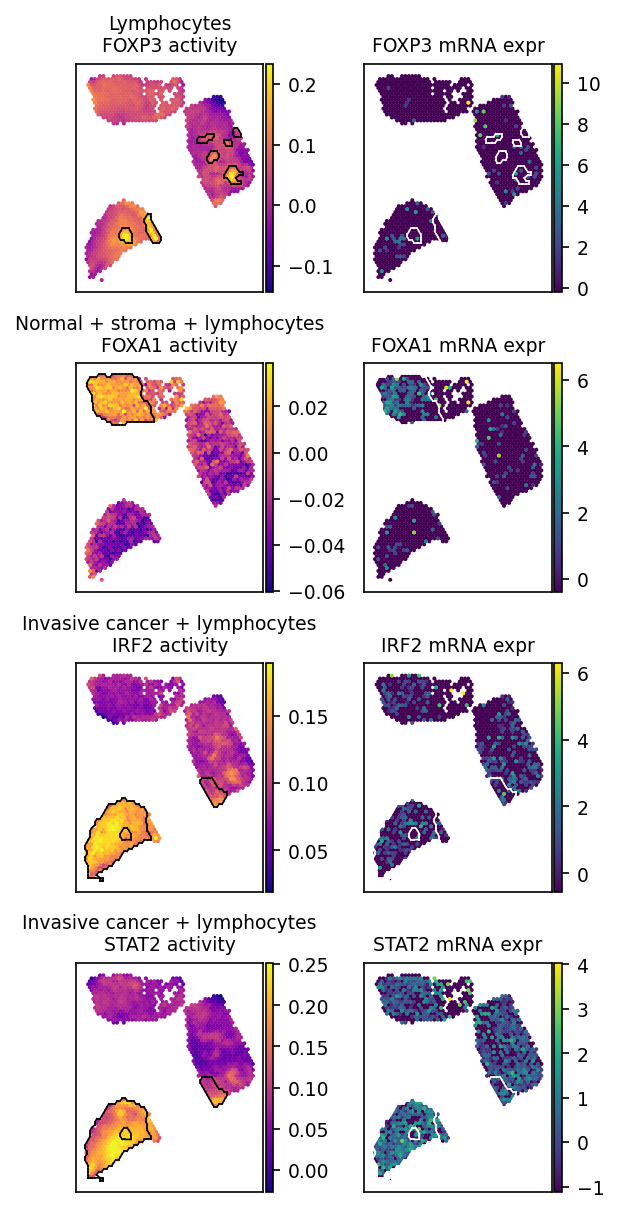

In [75]:
# Transposed figure layout (ngenes rows, 2 columns)

tf_region = [
    ['FOXP3', 'Lymphocytes', 'Lymphocytes'],
    ['FOXA1', 'Normal + stroma + lymphocytes', 'Normal + stroma + lymphocytes'],
    ['IRF2', 'Invasive cancer + lymphocytes', 'Invasive cancer + lymphocytes'],
    ['STAT2', 'Invasive cancer + lymphocytes', 'Invasive cancer + lymphocytes']
]

fig, axs = plt.subplots(ngenes, 2, figsize=(2*figsize*0.8, ngenes*figsize*0.8), dpi=dpi)

for i in range(ngenes):
    # Activity plot (now first column)
    sc.pl.spatial(adata_tfa, color=tf_region[i][0], 
                 size=1.8, alpha_img=0, color_map="plasma", ax=axs[i,0], show=False,
                 legend_fontsize=fontsize*0.8, colorbar_loc='right')
    
    # mRNA plot (now second column)
    sc.pl.spatial(adata, color=tf_region[i][0], 
                 size=1.8, alpha_img=0, color_map="viridis", ax=axs[i,1], show=False,
                 legend_fontsize=fontsize*0.8, colorbar_loc='right')
    
    # Update titles
    axs[i,0].set_title(tf_region[i][2] + '\n' + tf_region[i][0] + ' activity', fontsize=fontsize)
    axs[i,1].set_title(tf_region[i][0] + ' mRNA expr', fontsize=fontsize)
    
    # Remove axis labels
    for j in range(2):
        axs[i,j].set_xlabel("")
        axs[i,j].set_ylabel("")
    
    # Draw edges (note axs indices changed)
    edges = edge_list[tf_region[i][1]]
    points = points_list[tf_region[i][1]]
    for ii, jj in edges:
        axs[i,0].plot(points[[ii, jj], 0], points[[ii, jj], 1], 'k', linewidth=0.8)  # Activity plot
        axs[i,1].plot(points[[ii, jj], 0], points[[ii, jj], 1], 'w', linewidth=0.8)  # mRNA plot

plt.tight_layout(pad=0.6)